# 06 - Advanced: QCBM on TFIM Ground-State Samples

This notebook is an end-to-end training example:
1. build 1D TFIM Hamiltonian
2. compute exact ground-state distribution
3. sample training bitstrings from that distribution
4. train QCBM-style circuit with quasi-probability loss

Interpretation:
- `p_exact`: true TFIM ground-state probabilities
- `p_emp`: empirical distribution from finite samples
- `q`: model quasi-probabilities reconstructed from moments


In [1]:
import os
import sys
from itertools import combinations

try:
    cwd = os.getcwd()
except FileNotFoundError:
    cwd = os.environ.get("PWD", os.path.expanduser("~"))

repo_root = os.path.abspath(os.path.join(cwd, "..")) if os.path.basename(cwd) == "Tutorial" else cwd
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import numpy as np
import torch
from matplotlib import pyplot as plt

from src.pauli_surrogate_python import PauliRotation, CliffordGate
from src_tensor.api import build_quasi_sampler

In [2]:
def tfim_hamiltonian_dense(n_qubits: int, J: float = 1.0, h: float = 1.0, periodic: bool = False) -> np.ndarray:
    dim = 1 << n_qubits
    H = np.zeros((dim, dim), dtype=np.float64)

    # -J sum Z_i Z_{i+1}
    edge_end = n_qubits if periodic else n_qubits - 1
    for i in range(edge_end):
        j = (i + 1) % n_qubits
        for code in range(dim):
            zi = 1.0 if ((code >> i) & 1) == 0 else -1.0
            zj = 1.0 if ((code >> j) & 1) == 0 else -1.0
            H[code, code] += -J * zi * zj

    # -h sum X_i
    for i in range(n_qubits):
        flip = 1 << i
        for code in range(dim):
            H[code ^ flip, code] += -h
    return H

def tfim_ground_state_probs(n_qubits: int, J: float = 1.0, h: float = 1.0, periodic: bool = False):
    H = tfim_hamiltonian_dense(n_qubits, J=J, h=h, periodic=periodic)
    evals, evecs = np.linalg.eigh(H)
    gs = evecs[:, np.argmin(evals)]
    probs = np.abs(gs) ** 2
    probs /= np.sum(probs)
    return probs, float(np.min(evals))

def sample_from_probs_le(probs: np.ndarray, n_samples: int, rng: np.random.Generator) -> np.ndarray:
    n_qubits = int(np.log2(probs.shape[0]))
    codes = rng.choice(probs.shape[0], size=n_samples, p=probs)
    bits = np.zeros((n_samples, n_qubits), dtype=np.uint8)
    for i, code in enumerate(codes.tolist()):
        for q in range(n_qubits):
            bits[i, q] = (code >> q) & 1
    return bits

def build_qcbm_circuit(n_qubits: int, n_layers: int = 3):
    circuit = []
    pidx = 0
    for _ in range(n_layers):
        for q in range(n_qubits):
            circuit.append(PauliRotation('Y', [q], param_idx=pidx)); pidx += 1
        for q in range(n_qubits):
            circuit.append(PauliRotation('Z', [q], param_idx=pidx)); pidx += 1
        for q in range(n_qubits - 1):
            circuit.append(CliffordGate('CNOT', [q, q + 1]))
    return circuit, pidx

def all_combos_upto_order(n_qubits: int, order: int):
    combos = []
    for k in range(1, order + 1):
        combos.extend([list(c) for c in combinations(range(n_qubits), k)])
    return combos

## Hyperparameters and what they control\n
- `order`: max moment order used in quasi-prob reconstruction (higher = richer, costlier)\n
- `n_layers`: circuit depth/capacity\n
- `batch_size`, `steps`, `lr`: optimization dynamics\n
- `n_train_samples`: quality of empirical target distribution\n

In [3]:
# Problem setup
n_qubits = 12
order = 6
n_layers = 4
seed = 7
n_train_samples = 8192
batch_size = 8192
steps = 400
lr = 5e-3

rng = np.random.default_rng(seed)
torch.manual_seed(seed)

p_exact, e0 = tfim_ground_state_probs(n_qubits, J=1.5, h=1.0, periodic=False)
x_train = sample_from_probs_le(p_exact, n_train_samples, rng)
codes_train = (x_train.astype(np.int64) * (1 << np.arange(n_qubits, dtype=np.int64))[None, :]).sum(axis=1)
counts = np.bincount(codes_train, minlength=1 << n_qubits).astype(np.float64)
p_emp = counts / counts.sum()

print('TFIM E0:', e0)
print('dataset shape:', x_train.shape, 'unique states:', int(np.count_nonzero(counts)))

TFIM E0: -18.92537641600053
dataset shape: (8192, 12) unique states: 414


In [4]:
circuit, n_params = build_qcbm_circuit(n_qubits, n_layers=n_layers)
z_combos = all_combos_upto_order(n_qubits, order)



use_cuda = bool(torch.cuda.is_available())
device = 'cuda' if use_cuda else 'cpu'
thetas = torch.nn.Parameter(0.1 * torch.randn((n_params,), dtype=torch.float64, device=device))
if use_cuda:
    sampler = build_quasi_sampler(
        n_qubits=n_qubits,
        circuit=circuit,
        z_combos=z_combos,
        max_order=order,
        preset='gpu_min',
        preset_overrides={'max_weight':15,'max_xy':15},
        build_thetas=thetas,build_min_abs=1e-3,build_min_mat_abs=1e-3,
    )

else:
    sampler = build_quasi_sampler(
        n_qubits=n_qubits,
        circuit=circuit,
        z_combos=z_combos,
        max_order=order,
        preset='gpu_min',
        preset_overrides={
            'build_device': 'cpu',
            'step_device': 'cpu',
            'stream_device': 'cpu',
            'dtype': 'float64',
            'max_weight': 1_000_000_000,
            'max_xy': 1_000_000_000,
            'offload_steps': False,
            'offload_back': False,
        },
    )



opt = torch.optim.Adam([thetas], lr=lr)
p_emp_t = torch.tensor(p_emp, dtype=torch.float64, device=device)
x_train_t = torch.tensor(x_train, dtype=torch.uint8, device=device)
codes_t = torch.tensor(codes_train, dtype=torch.long, device=device)

print('device:', device, 'n_params:', n_params, 'n_obs:', sampler.n_observables)

propagate: 100%|██████████| 140/140 [00:06<00:00, 20.20it/s]


zero_filter_backprop: K 2509->2509 (1.000), n_out 992173->3637 (0.004), dt=0.537s
device: cuda n_params: 96 n_obs: 2509


In [5]:
# Training loop with early stopping
history = []

early_stop = True
min_steps = 50            # don't early-stop too early
patience = 80             # stop if no improvement for this many steps
min_delta = 1e-4          # required absolute improvement in loss
restore_best = True       # restore best thetas when stopping

best_loss = float('inf')
best_step = -1
best_thetas = None

for step in range(steps):
    opt.zero_grad(set_to_none=True)

    idx = torch.randint(0, x_train_t.shape[0], (batch_size,), device=device)
    xb = x_train_t[idx]
    target = p_emp_t[codes_t[idx]]

    moments = sampler.compute_moments(thetas, stream_device=device, offload_back=False)
    q = sampler.quasi_prob_from_moments(xb, moments, order=order)

    loss = torch.mean((q - target) ** 2)
    loss.backward()
    grad = thetas.grad
    grad_norm = float(torch.linalg.vector_norm(grad.detach()).cpu()) if grad is not None else float('nan')
    opt.step()

    loss_val = float(loss.detach().cpu())
    history.append(loss_val)

    # early stopping bookkeeping
    improved = (loss_val + min_delta) < best_loss
    if improved:
        best_loss = loss_val
        best_step = step
        if restore_best:
            best_thetas = thetas.detach().clone()

    if step % 20 == 0 or step == steps - 1:
        stall = step - best_step
        with torch.no_grad():
            print(
                f'step={step:04d} loss={loss_val:.6e} best={best_loss:.6e} ',
                f'stall={stall:4d} grad_norm={grad_norm:.3e} q_mean={float(q.mean().detach().cpu()):.3e}',
            )

    if early_stop and step >= min_steps and (step - best_step) >= patience:
        print(f'Early stop at step={step} (best_loss={best_loss:.6e} at step={best_step})')
        if restore_best and best_thetas is not None:
            with torch.no_grad():
                thetas.copy_(best_thetas)
        break

step=0000 loss=2.988922e-02 best=2.988922e-02  stall=   0 grad_norm=2.832e-02 q_mean=1.917e-01
step=0020 loss=1.454043e-02 best=1.454043e-02  stall=   0 grad_norm=1.421e-02 q_mean=1.330e-01
step=0040 loss=1.293993e-02 best=1.225308e-02  stall=   5 grad_norm=6.901e-03 q_mean=1.009e-01
step=0060 loss=1.190966e-02 best=1.183243e-02  stall=  12 grad_norm=6.930e-03 q_mean=1.091e-01
step=0080 loss=1.060428e-02 best=1.060428e-02  stall=   0 grad_norm=8.574e-03 q_mean=1.137e-01
step=0100 loss=9.595357e-03 best=9.337122e-03  stall=   4 grad_norm=1.020e-02 q_mean=1.173e-01
step=0120 loss=7.671889e-03 best=7.671889e-03  stall=   0 grad_norm=1.119e-02 q_mean=1.239e-01
step=0140 loss=6.169063e-03 best=5.988835e-03  stall=   2 grad_norm=1.224e-02 q_mean=1.295e-01
step=0160 loss=4.234183e-03 best=4.192530e-03  stall=   1 grad_norm=1.163e-02 q_mean=1.369e-01
step=0180 loss=2.751409e-03 best=2.787452e-03  stall=   1 grad_norm=1.052e-02 q_mean=1.430e-01
step=0200 loss=1.587762e-03 best=1.587762e-03  sta

L1(surrogate q, exact TFIM): 7.463843709763486
L1(PennyLane model, exact TFIM): 0.7159722062129897


/home/ubuntu/miniconda3/envs/pps-dev/lib/python3.11/site-packages/pennylane/__init__.py:212: PennyLaneDeprecationWarning: PennyLane v0.44 has dropped maintainence support for NumPy < 2.0.0. You have version 1.26.4 installed. Future versions of PennyLane will not work with NumPy<2.0. Please consider upgrading NumPy using `python -m pip install numpy --upgrade`. 
  warnings.warn(


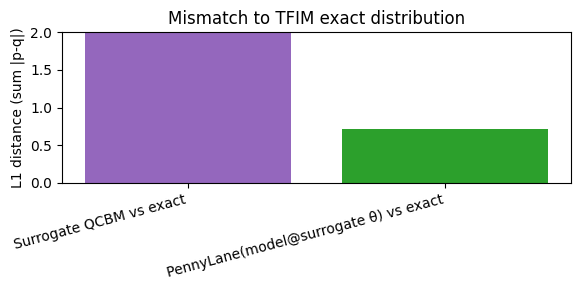

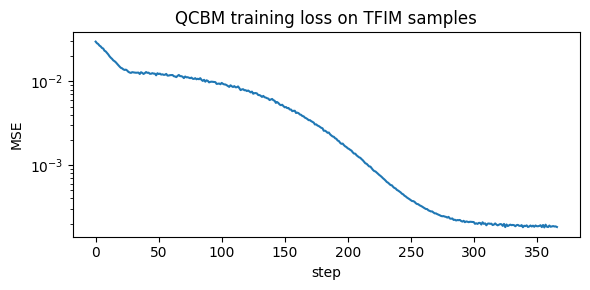

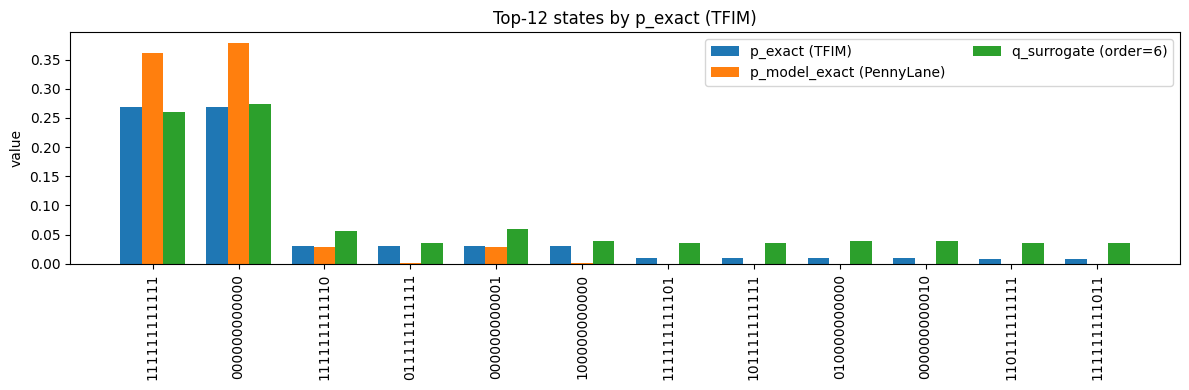

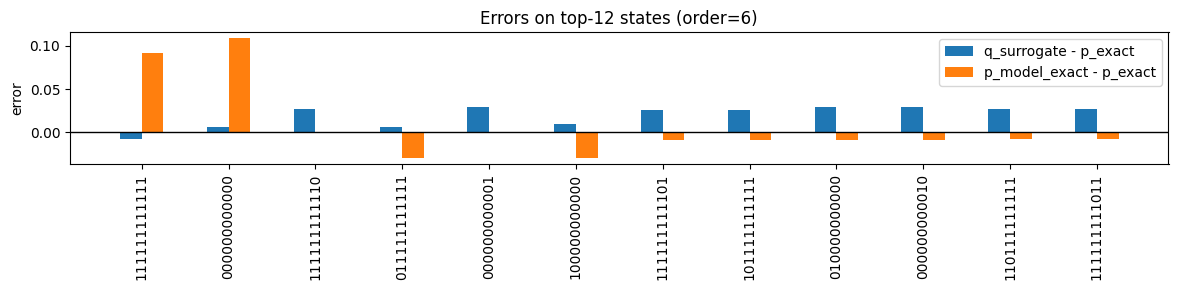

: 

In [ ]:
# Evaluate on all states (small n only)
try:
    from src_tensor.api import pennylane_reference_probs
except ImportError:
    # If the kernel already imported an older src_tensor.api, reload it.
    import importlib
    import src_tensor.api as _tensor_api
    importlib.reload(_tensor_api)
    pennylane_reference_probs = _tensor_api.pennylane_reference_probs

all_rows = np.array([[(code >> q) & 1 for q in range(n_qubits)] for code in range(1 << n_qubits)], dtype=np.uint8)
all_bits = torch.tensor(all_rows, dtype=torch.uint8, device=device)

with torch.no_grad():
    moments = sampler.compute_moments(thetas, stream_device=device, offload_back=False)
    q_all = sampler.quasi_prob_from_moments(all_bits, moments, order=order).detach().cpu().numpy()

# PennyLane exact model probabilities (statevector) at surrogate-trained parameters
p_model = pennylane_reference_probs(sampler, thetas, seed=0, bit_order='le').detach().cpu().numpy().astype(np.float64)

# Metrics: two comparisons only
l1_surrogate_vs_exact = float(np.sum(np.abs(q_all - p_exact)))
l1_pennylane_vs_exact = float(np.sum(np.abs(p_model - p_exact)))

print('L1(surrogate q, exact TFIM):', l1_surrogate_vs_exact)
print('L1(PennyLane model, exact TFIM):', l1_pennylane_vs_exact)

# L1 comparison bar plot
plt.figure(figsize=(6, 3))
plt.bar(
    ['Surrogate QCBM vs exact', 'PennyLane(model@surrogate θ) vs exact'],
    [l1_surrogate_vs_exact, l1_pennylane_vs_exact],
    color=['tab:purple', 'tab:green'],
 )
plt.ylim(0.0, 2.0)
plt.ylabel('L1 distance (sum |p-q|)')
plt.title('Mismatch to TFIM exact distribution')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

# Training curve
plt.figure(figsize=(6, 3))
plt.plot(history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('MSE')
plt.title('QCBM training loss on TFIM samples')
plt.tight_layout()
plt.show()

# Plot top states by TFIM exact distribution
def _bits_str_be(bits_le_row):
    return ''.join(str(int(v)) for v in bits_le_row[::-1])

top_k = 12
top = np.argsort(-p_exact)[:top_k]
labels = [_bits_str_be(all_rows[i]) for i in top]
p_exact_top = p_exact[top]
p_model_top = p_model[top]
q_top = q_all[top]

x = np.arange(top_k)
w = 0.25

plt.figure(figsize=(12, 4))
plt.bar(x - w, p_exact_top, width=w, label='p_exact (TFIM)')
plt.bar(x + 0*w, p_model_top, width=w, label='p_model_exact (PennyLane)')
plt.bar(x + w, q_top, width=w, label=f'q_surrogate (order={order})')
plt.xticks(x, labels, rotation=90)
plt.ylabel('value')
plt.title(f'Top-{top_k} states by p_exact (TFIM)')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.bar(x - w/2, q_top - p_exact_top, width=w, label='q_surrogate - p_exact')
plt.bar(x + w/2, p_model_top - p_exact_top, width=w, label='p_model_exact - p_exact')
plt.axhline(0.0, color='black', linewidth=1)
plt.xticks(x, labels, rotation=90)
plt.ylabel('error')
plt.title(f'Errors on top-{top_k} states (order={order})')
plt.legend()
plt.tight_layout()
plt.show()